<a href="https://colab.research.google.com/github/quainhan1110/DogsandCats-Classification/blob/main/source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dogs and Cats Classification

Implement model to identify dog and cat images using Residual Network (ResNes), released by Microsoft.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/3362/media/woof_meow.jpg)

# Library declaration

Declare all necessary libraries and functions in Tensorflow to build and train deep learning model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.cm as cm
import os                  
import shutil              
from pathlib import Path
import random
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.imagenet_utils import decode_predictions


In [2]:
# check version of Python and Tensorflow
!python --version
print("TensorFlow:",tf.__version__)

Python 3.7.14
TensorFlow: 2.8.2


In [3]:
!nvidia-smi

Mon Sep 26 02:56:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# default size of images
HEIGHT = 224
WIDTH = 224

# Download and extract dog and cat images

In [5]:
!wget 'https://s3.amazonaws.com/fast-ai-sample/dogscats.tgz'

--2022-09-26 02:56:47--  https://s3.amazonaws.com/fast-ai-sample/dogscats.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.42.72
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.42.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 839285364 (800M) [application/x-tar]
Saving to: ‘dogscats.tgz’

dogscats.tgz        100%[===================>] 800.40M  45.9MB/s    in 18s     

2022-09-26 02:57:06 (44.7 MB/s) - ‘dogscats.tgz’ saved [839285364/839285364]



In [6]:
!tar -xzf dogscats.tgz

# Check data

In [7]:
DATA_PATH = Path('./dogscats')
dog_paths = [str(i) for i in (DATA_PATH/'train/dogs').glob('*') if i.is_file()]
cat_paths = [str(i) for i in (DATA_PATH/'train/cats').glob('*') if i.is_file()]

In [8]:
dog_paths[:5]

['dogscats/train/dogs/dog.2812.jpg',
 'dogscats/train/dogs/dog.11374.jpg',
 'dogscats/train/dogs/dog.899.jpg',
 'dogscats/train/dogs/dog.637.jpg',
 'dogscats/train/dogs/dog.7144.jpg']

In [9]:
cat_paths[:5]

['dogscats/train/cats/cat.3923.jpg',
 'dogscats/train/cats/cat.3509.jpg',
 'dogscats/train/cats/cat.1175.jpg',
 'dogscats/train/cats/cat.8992.jpg',
 'dogscats/train/cats/cat.11106.jpg']

In [10]:
#number of data
print(f"Number of dog images in our train dataset: {len(dog_paths)}")
print(f"Number of cat images int our train dataset: {len(cat_paths)}")

Number of dog images in our train dataset: 11500
Number of cat images int our train dataset: 11500


Display some images by ```show_gallery``` function

In [11]:
def reset_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
reset_seed()

def get_side(img, side_type, n = 5):
    h, w, c = img.shape
    if side_type == "horizontal":
        return np.ones((h,n,c))
    return np.ones((n,w,c))

def show_gallery(im_ls,n=5, shuffle=True):
    images = []
    vertical_images = []
    if shuffle:
        random.shuffle(im_ls)
    vertical_images = []
    for i in range(n*n):
        img = load_img(im_ls[i], target_size=(HEIGHT,WIDTH))
        img = img_to_array(img)
        hside = get_side(img,side_type="horizontal")
        images.append(img)
        images.append(hside)
        
        if (i+1) % n == 0:
            himage=np.hstack((images))
            vside = get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images = []
        
    gallery = np.vstack((vertical_images))
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(gallery.astype(np.uint8))
    plt.show()

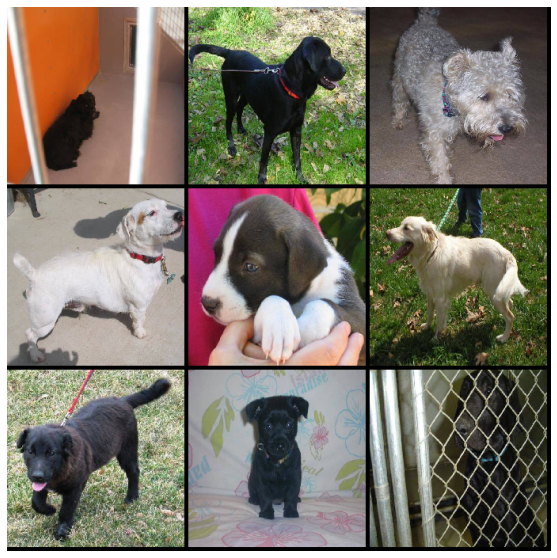

In [12]:
# Show dog images
show_gallery(dog_paths, n=3)

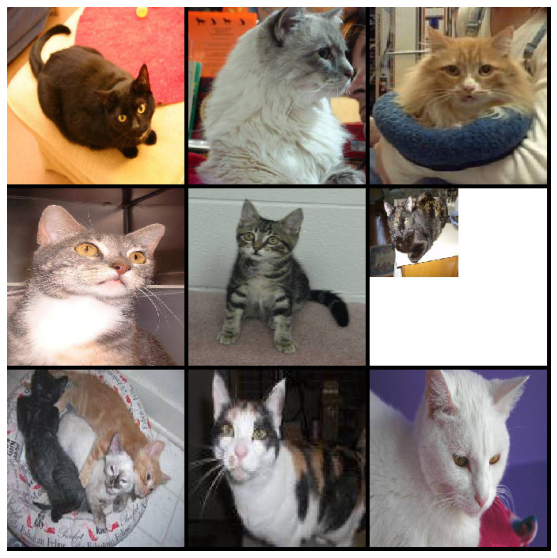

In [13]:
# Show cats images
show_gallery(cat_paths, n=3)

# Build and train deep learning model by Tensorflow

In [14]:
def prepare_data(batch_size):
    train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
    val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

    train_generator = train_datagen.flow_from_directory(
                            DATA_PATH/'train', 
                            target_size=(HEIGHT,WIDTH),
                            batch_size=batch_size,
                            shuffle=True,
                            seed=42,
                            class_mode='categorical')
    
    validation_generator = val_datagen.flow_from_directory(
                            DATA_PATH/'valid',
                            target_size=(HEIGHT,WIDTH),
                            batch_size=batch_size,
                            shuffle=False,
                            class_mode='categorical')
    
    return train_generator,validation_generator


BATCH_SIZE = 32
train_generator,val_generator = prepare_data(BATCH_SIZE)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# Choose deep learning model

In this kernel, we use Residual Networks model (aka ResNet), released by Microsoft.
The illustration of this model:
![](https://images.viblo.asia/full/fe5b21e5-3ad3-4419-93e0-7aa77a662bdd.png)

In [15]:
resnet = ResNet50V2(include_top=False, pooling="avg", weights='imagenet')
for layer in resnet.layers:
    layer.trainable=False

logits = Dense(2)(resnet.output)
output = Activation('softmax')(logits)
model = Model(resnet.input, output)

94683136/94668760 [==============================] - 1s 0us/step


Check information of deep learning model

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

Choose **Stochastic Gradient Descent** for the optimizer to reduce **loss function**, increase efficiency of model

In [17]:
sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [18]:
model.compile(optimizer=sgd, loss = "categorical_crossentropy", metrics=["accuracy"])

Save the best model while training

In [19]:
checkpointer = ModelCheckpoint(filepath="./resnet50best.h5", monitor='val_loss', save_best_only=True, mode='auto')

Training model 3 times

In [20]:
history = model.fit(
    train_generator, 
    epochs=3,
    validation_data=val_generator,
    callbacks=[checkpointer]
)

Epoch 1/3
719/719 [==============================] - 115s 140ms/step - loss: 0.0733 - accuracy: 0.9820 - val_loss: 0.0513 - val_accuracy: 0.9860
Epoch 2/3
719/719 [==============================] - 97s 134ms/step - loss: 0.0461 - accuracy: 0.9883 - val_loss: 0.0544 - val_accuracy: 0.9855
Epoch 3/3
719/719 [==============================] - 97s 135ms/step - loss: 0.0392 - accuracy: 0.9896 - val_loss: 0.1011 - val_accuracy: 0.9805


# GradCAM 

Using GradCAM to determine what detail the model is based on to give results

In [21]:
#@title Run this cell to load GradCAM

class GradCAM:
    def __init__(self, model, layerName=None):
        """
        model: pre-softmax layer (logit layer)
        """
        self.model = model
        self.layerName = layerName
            
        if self.layerName == None:
            self.layerName = self.find_target_layer()
    
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM")
            
    def compute_heatmap(self, image, classIdx, upsample_size, eps=1e-5):
        gradModel = Model(
            inputs = [self.model.inputs],
            outputs = [self.model.get_layer(self.layerName).output, self.model.output]
        )
        # record operations for automatic differentiation
        
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOuts, preds) = gradModel(inputs) # preds after softmax
            loss = preds[:,classIdx]
        
        # compute gradients with automatic differentiation
        grads = tape.gradient(loss, convOuts)
        # discard batch
        convOuts = convOuts[0]
        grads = grads[0]
        norm_grads = tf.divide(grads, tf.reduce_mean(tf.square(grads)) + tf.constant(eps))
        
        # compute weights
        weights = tf.reduce_mean(norm_grads, axis=(0,1))
        cam = tf.reduce_sum(tf.multiply(weights, convOuts), axis=-1)
        
        # Apply reLU
        cam = np.maximum(cam, 0)
        cam = cam/np.max(cam)
        cam = cv2.resize(cam, upsample_size,interpolation=cv2.INTER_LINEAR)
        
        # convert to 3D
        cam3 = np.expand_dims(cam, axis=2)
        cam3 = np.tile(cam3, [1,1,3])
        
        return cam3
    
def overlay_gradCAM(img, cam3):
    cam3 = np.uint8(255*cam3)
    cam3 = cv2.applyColorMap(cam3, cv2.COLORMAP_JET)
    
    new_img = 0.3*cam3 + 0.5*img
    
    return (new_img*255.0/new_img.max()).astype("uint8")


@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

class GuidedBackprop:
    def __init__(self,model, layerName=None):
        self.model = model
        self.layerName = layerName
        self.gbModel = self.build_guided_model()
        
        if self.layerName == None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply Guided Backpropagation")

    def build_guided_model(self):
        gbModel = Model(
            inputs = [self.model.inputs],
            outputs = [self.model.get_layer(self.layerName).output]
        )
        layer_dict = [layer for layer in gbModel.layers[1:] if hasattr(layer,"activation")]
        for layer in layer_dict:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guidedRelu
        
        return gbModel
    
    def guided_backprop(self, images, upsample_size):
        """Guided Backpropagation method for visualizing input saliency."""
        with tf.GradientTape() as tape:
            inputs = tf.cast(images, tf.float32)
            tape.watch(inputs)
            outputs = self.gbModel(inputs)

        grads = tape.gradient(outputs, inputs)[0]

        saliency = cv2.resize(np.asarray(grads), upsample_size)

        return saliency

def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Function of GradCAM visualization

In [22]:
def show_gradCAMs(model, gradCAM, GuidedBP, im_ls, n=3, decode={}):
    """
    model: softmax layer
    """
    random.shuffle(im_ls)
    plt.subplots(figsize=(15, 5*n))
    k=1
    for i in range(n):
        img = cv2.imread(im_ls[i])
        upsample_size = (img.shape[1],img.shape[0])
        # Show original image
        plt.subplot(n,3,k)
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        plt.title("Filename: {}".format(im_ls[i]), fontsize=10)
        plt.axis("off")
        # Show overlayed grad
        plt.subplot(n,3,k+1)
        im = img_to_array(load_img(im_ls[i], target_size=(HEIGHT,WIDTH)))
        x = np.expand_dims(im, axis=0)
        x = preprocess_input(x)
        preds = model.predict(x)
        idx = preds.argmax()
        if len(decode)==0:
            res = decode_predictions(preds)[0][0][1:]
        else:
            res = [decode[idx],preds.max()]
        cam3 = gradCAM.compute_heatmap(image=x, classIdx=idx, upsample_size=upsample_size)
        new_img = overlay_gradCAM(img, cam3)
        new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
        plt.imshow(new_img)
        plt.title("GradCAM - Pred: {}. Prob: {}%".format(res[0],round(res[1]*100,2)), fontsize=10)
        plt.axis("off")
        
        # Show guided GradCAM
        plt.subplot(n,3,k+2)
        gb = GuidedBP.guided_backprop(x, upsample_size)
        guided_gradcam = deprocess_image(gb*cam3)
        guided_gradcam = cv2.cvtColor(guided_gradcam, cv2.COLOR_BGR2RGB)
        plt.imshow(guided_gradcam)
        plt.title("Guided GradCAM", fontsize=10)
        plt.axis("off")
        
        k += 3
    plt.show()

Load the best model

In [23]:
model.load_weights("./resnet50best.h5")

Prepare for GradCAM Visualization

In [24]:
model_logit = Model(model.input,model.layers[-2].output)
gradCAM = GradCAM(model=model_logit, layerName="conv5_block3_out")
guidedBP = GuidedBackprop(model=model,layerName="conv5_block3_out")

In [25]:
predictions = model.predict(val_generator, verbose = 1)
pred_indices = np.argmax(predictions,axis=1)

ground_truth = val_generator.classes
filenames = np.array(val_generator.filenames)

63/63 [==============================] - 8s 122ms/step


## Visualize the result of model

Correct dog images prediction path

In [26]:
dogs_correct_path = filenames[(pred_indices == ground_truth) & (ground_truth==1)]
dogs_correct_path = list(map(lambda x: str(DATA_PATH/'valid'/x),dogs_correct_path))

How model predict dog images

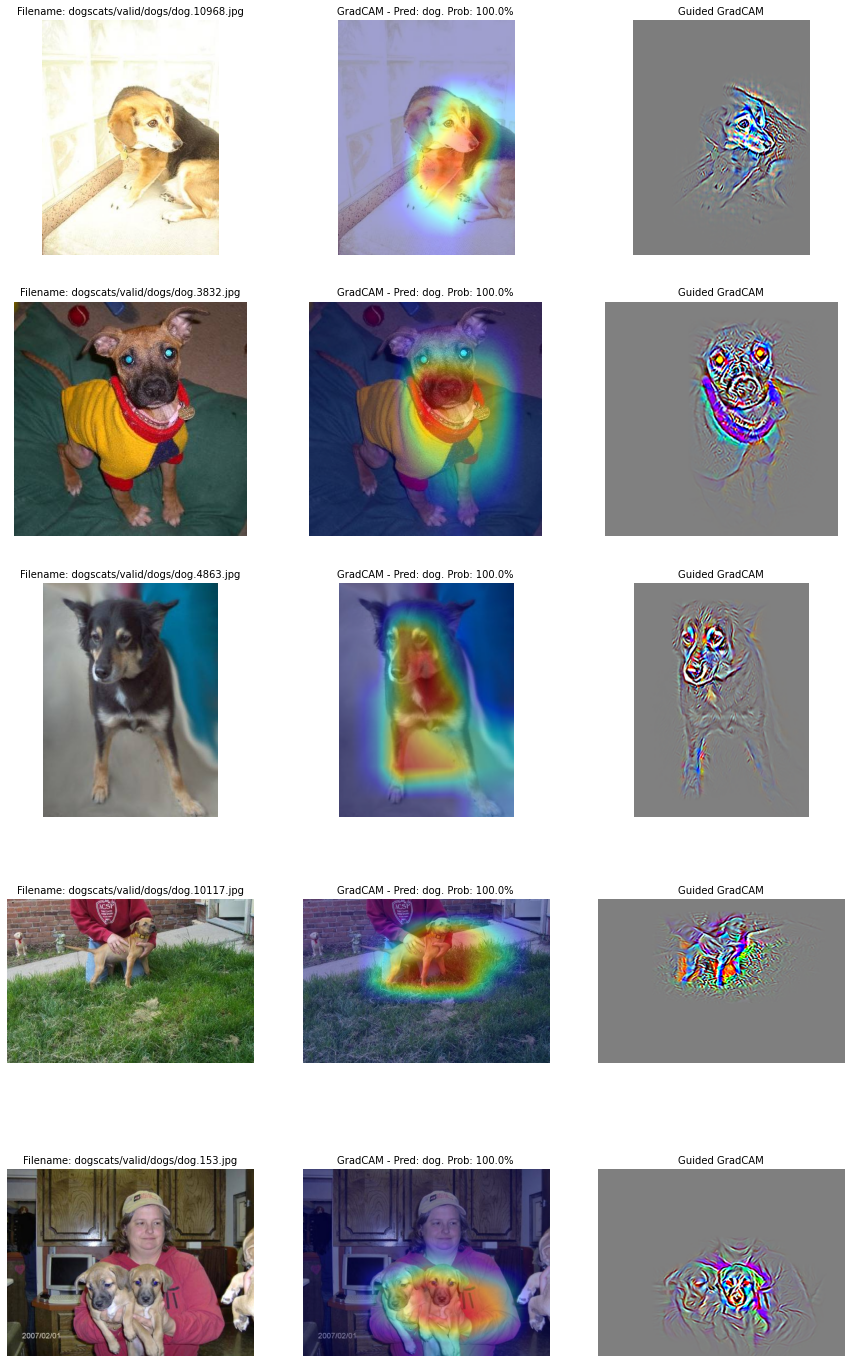

In [27]:
show_gradCAMs(model, gradCAM,guidedBP,dogs_correct_path, n=5, decode={0:"cat", 1:"dog"})

Correct cat images prediction path

In [28]:
cats_correct_path = filenames[(pred_indices == ground_truth) & (ground_truth==0)]
cats_correct_path = list(map(lambda x: str(DATA_PATH/'valid'/x),cats_correct_path))

How model predict cat images

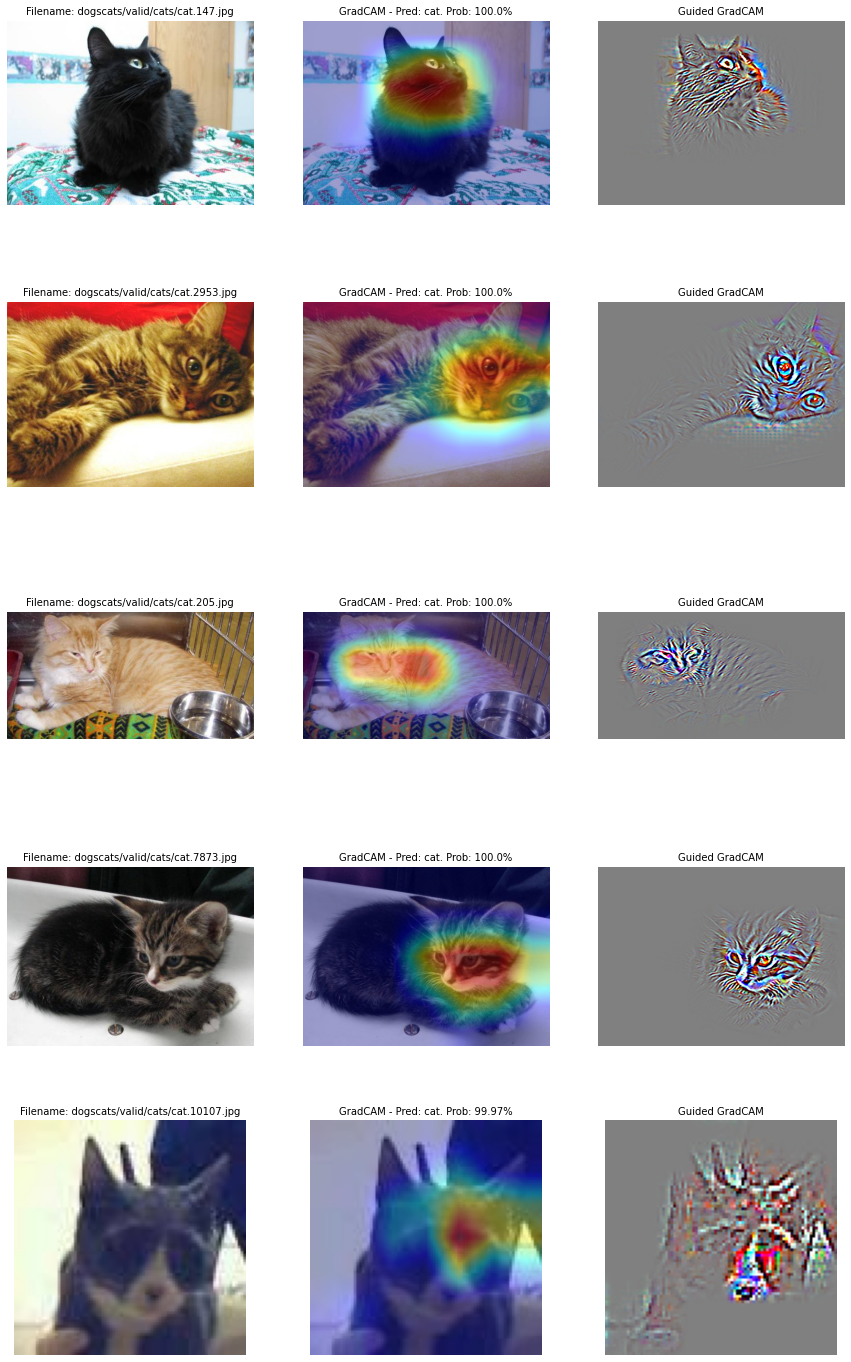

In [29]:
show_gradCAMs(model, gradCAM,guidedBP,cats_correct_path, n=5, decode={0:"cat", 1:"dog"})

# Wrong prediction

## Predict cat in dog images



In [30]:
cat_but_actually_dog_path = filenames[(pred_indices != ground_truth) & (ground_truth==1)]
cat_but_actually_dog_path = list(map(lambda x: str(DATA_PATH/'valid'/x),cat_but_actually_dog_path))

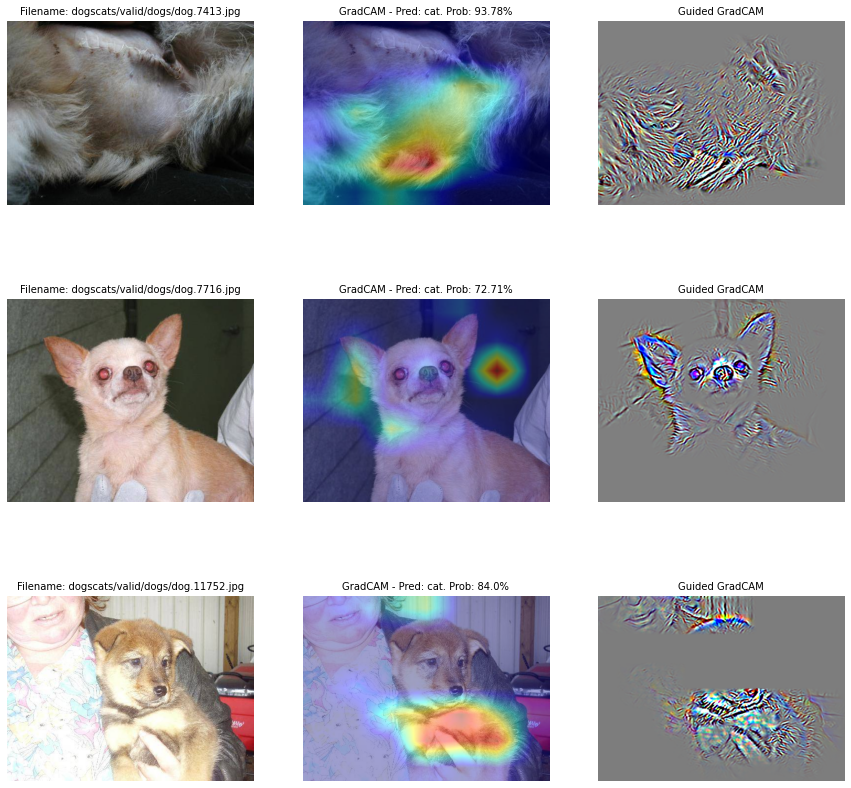

In [31]:
show_gradCAMs(model, gradCAM,guidedBP,cat_but_actually_dog_path, n=3, decode={0:"cat", 1:"dog"})

## Predict dog in cat images


In [32]:
dog_but_actually_cat_path = filenames[(pred_indices != ground_truth) & (ground_truth==0)]
dog_but_actually_cat_path = list(map(lambda x: str(DATA_PATH/'valid'/x),dog_but_actually_cat_path))

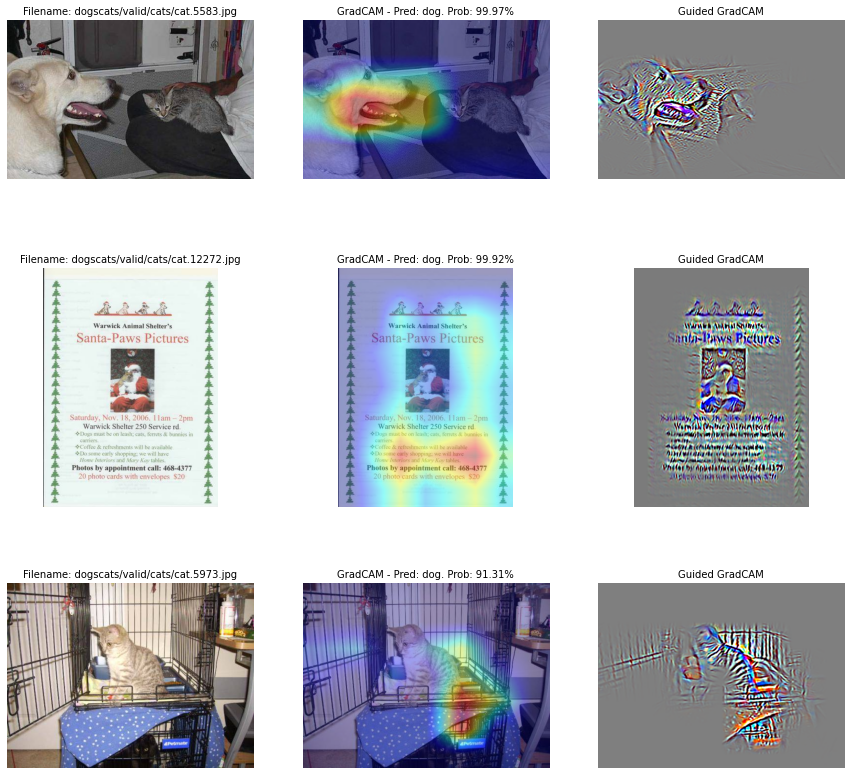

In [33]:
show_gradCAMs(model, gradCAM,guidedBP,dog_but_actually_cat_path, n=3, decode={0:"cat", 1:"dog"})

# Check model by upload image

In [34]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  uploaded_path = '/content/' + fn
  print(f'You have uploaded this image file: {uploaded_path}' )

Saving _124300663_cat.jpg to _124300663_cat.jpg
You have uploaded this image file: /content/_124300663_cat.jpg


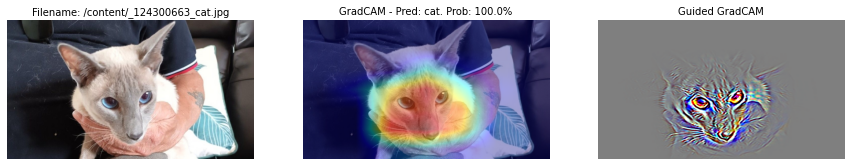

In [35]:
show_gradCAMs(model, gradCAM,guidedBP,[uploaded_path], n=1, decode={0:"cat", 1:"dog"})

# Reference
https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
https://www.kaggle.com/code/serkanpeldek/keras-cnn-transfer-learnings-on-cats-dogs-dataset/notebook